In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import cv2

image = cv2.imread('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/mild_119.jpg')

In [3]:
image_shape = image.shape
print(image_shape)

(128, 128, 3)


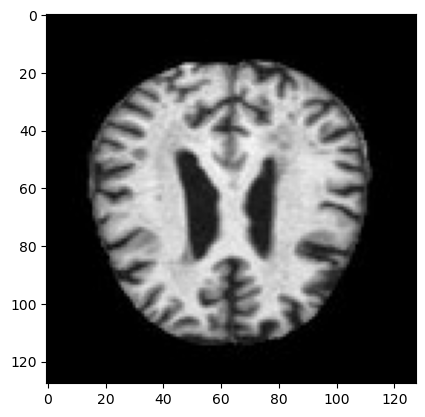

In [4]:
plt.imshow(image)

In [5]:
import glob

mild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
moderate = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
verymild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []
labels = []

#image_size = (32,32)

for i in mild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(0)
    
for i in moderate:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(1)

for i in non:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(2)

for i in verymild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(3)

    
x=np.array(data)
y=np.array(labels)
print(f'Dataset Shape: {x.shape}, Labels Shape: {y.shape}')

Dataset Shape: (6400, 128, 128, 3), Labels Shape: (6400,)


In [6]:
from sklearn.model_selection import train_test_split

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Perform train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [7]:
x_train[0].shape

(128, 128, 3)

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

def inceptionBlock(inputs, filters, name=None):
    # Branch 1
    x1 = Conv2D(filters[0], 1, padding='same', activation='relu')(inputs)

    # Branch 2
    x2 = Conv2D(filters[1], 1, padding='same', activation='relu')(inputs)
    x2 = Conv2D(filters[2], 3, padding='same', activation='relu')(x2)

    # Branch 3
    x3 = Conv2D(filters[3], 1, padding='same', activation='relu')(inputs)
    x3 = Conv2D(filters[4], 5, padding='same', activation='relu')(x3)

    # Branch 4
    x4 = MaxPooling2D(pool_size=3, strides=1, padding='same')(inputs)
    x4 = Conv2D(filters[5], 1, padding='same', activation='relu')(x4)

    # Output layer concatenated
    outputs = Concatenate()([x1, x2, x3, x4])

    return outputs


# Define the input shape
input_shape = x_train[0].shape

# Define the input tensor
inputs = Input(shape=input_shape)


# First conv layer
x = Conv2D(64, 7, strides=2, padding='same', activation='relu', name='layer_1_conv7x7')(inputs)
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='layer_1_maxpool')(x)
x = tf.nn.local_response_normalization(x)  # Apply LRN


# Second conv layer
x = Conv2D(64, 1, strides=1, padding='same', activation='relu', name='layer_2_conv3x3red')(x)
x = Conv2D(192, 3, strides=1, padding='same', activation='relu', name='layer_2_conv3x3')(x)
x = tf.nn.local_response_normalization(x)  # Apply LRN
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='layer_2_maxpool')(x)


# Third conv layer with inception
x = inceptionBlock(x, [64, 96, 128, 16, 32, 32], name='inception_3a')
x = inceptionBlock(x, [128, 128, 192, 32, 96, 64], name='inception_3b')
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='layer_3_maxpool')(x)


# Fourth conv layer with inception
x = inceptionBlock(x, [192, 96, 208, 16, 48, 64], name='inception_4a')

# Out 1
x1 = AveragePooling2D(pool_size=5, strides=3, padding='same', name='layer_4a_avgpool')(x)
x1 = Conv2D(128, 1, padding='same', activation='relu', name='out_1_conv1x1')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu', name='dense1024_out_1')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='out_1')(x1)

x = inceptionBlock(x, [160, 112, 224, 24, 64, 64], name='inception_4b')
x = inceptionBlock(x, [128, 128, 256, 24, 64, 64], name='inception_4c')
x = inceptionBlock(x, [112, 144, 288, 32, 64, 64], name='inception_4d')

# Out 2
x2 = AveragePooling2D(pool_size=5, strides=3, padding='same', name='layer_4d_avgpool')(x)
x2 = Conv2D(128, 1, padding='same', activation='relu', name='out_2_conv1x1')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu', name='dense1024_out_2')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='out_2')(x2)

x = inceptionBlock(x, [256, 160, 320, 32, 128, 128], name='inception_4e')
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='layer_4_maxpool')(x)


# Fifth conv layer with inception
x = inceptionBlock(x, [256, 160, 320, 32, 128, 128], name='inception_5a')
x = inceptionBlock(x, [384, 192, 384, 48, 128, 128], name='inception_5b')
x = AveragePooling2D(pool_size=7, strides=1, padding='same', name='layer_5b_avgpool')(x)


# Outputs
x = Flatten()(x)
x = Dropout(0.4)(x)
# Output layer
outputs = Dense(1000, activation='softmax', name='outputs')(x)

# Create the model
model = Model(inputs, outputs, name='GoogLeNet')

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

# Print the summary of the model
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 layer_1_conv7x7 (Conv2D)       (None, 64, 64, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 layer_1_maxpool (MaxPooling2D)  (None, 32, 32, 64)  0           ['layer_1_conv7x7[0][0]']        
                                                                                                  
 tf.nn.local_response_normaliza  (None, 32, 32, 64)  0           ['layer_1_maxpool[0][0]']

In [9]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="GoogLeNet.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1200,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

In [10]:
from sklearn.utils import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Class weight setting for imbalanced dataset
#class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
#class_weights = dict(zip(np.unique(y_train), class_weights))

# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss for learning rate reduction
    factor=0.5,            # Reduce learning rate by a factor
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Minimum learning rate
)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('GoogLeNet_best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 40
batch_size = 128
history = model.fit(x_train, y_train, 
                    validation_data = (x_val,y_val), 
                    #class_weight = class_weights, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    callbacks = [lr_callback,checkpoint_callback,early_stopping_callback]
                   )

# Evaluate the model
GoogLeNet_best_model = tf.keras.models.load_model('GoogLeNet_best_model.h5')
loss, accuracy = GoogLeNet_best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# Make predictions on new images
predictions = GoogLeNet_best_model.predict(x_test[:10])
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class and corresponding true class
for i in range(len(predicted_classes)):
    print(f"Predicted class: {predicted_classes[i]}, True class: {np.argmax(y_test[i])}")

Epoch 1/40
32/32 [==============================] - 49s 381ms/step - loss: 1.9673 - accuracy: 0.3857 - val_loss: 1.0248 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/40
32/32 [==============================] - 10s 313ms/step - loss: 1.0499 - accuracy: 0.4897 - val_loss: 1.0260 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 3/40
32/32 [==============================] - 11s 345ms/step - loss: 1.0488 - accuracy: 0.4968 - val_loss: 1.0208 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 4/40
32/32 [==============================] - 11s 331ms/step - loss: 1.0446 - accuracy: 0.4941 - val_loss: 1.0221 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 5/40
32/32 [==============================] - 10s 313ms/step - loss: 1.0480 - accuracy: 0.4937 - val_loss: 1.0216 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 6/40
32/32 [==============================] - 10s 313ms/step - loss: 1.0455 - accuracy: 0.4888 - val_loss: 1.0278 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 7/40
32/32 [==============================] - 11s 330ms/st

In [11]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = GoogLeNet_best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(['mild','moderate','non','verymild'])
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

40/40 [==============================] - 1s 22ms/step
Classification Report:
               precision    recall  f1-score   support

        mild       0.39      0.09      0.15       201
    moderate       0.00      0.00      0.00         6
         non       0.71      0.63      0.66       643
    verymild       0.41      0.62      0.49       430

    accuracy                           0.54      1280
   macro avg       0.37      0.34      0.33      1280
weighted avg       0.55      0.54      0.52      1280



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


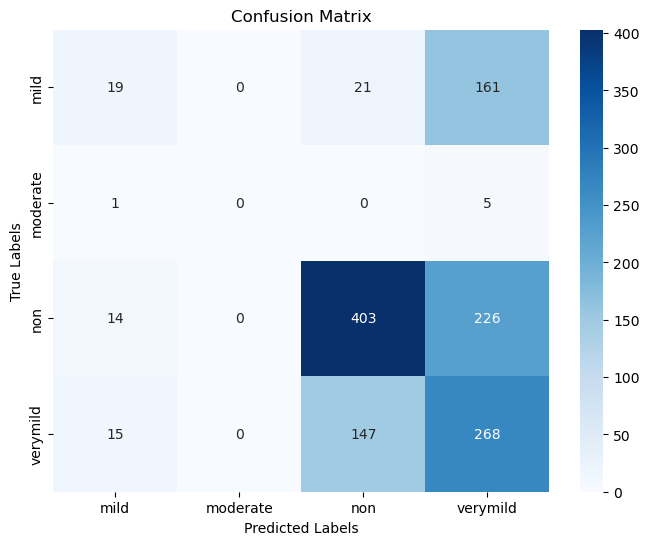

In [12]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

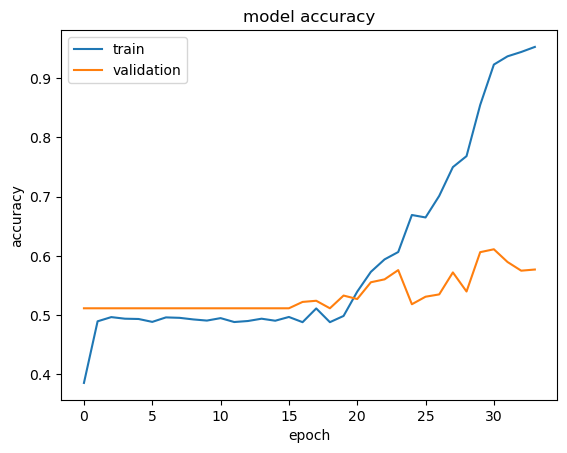

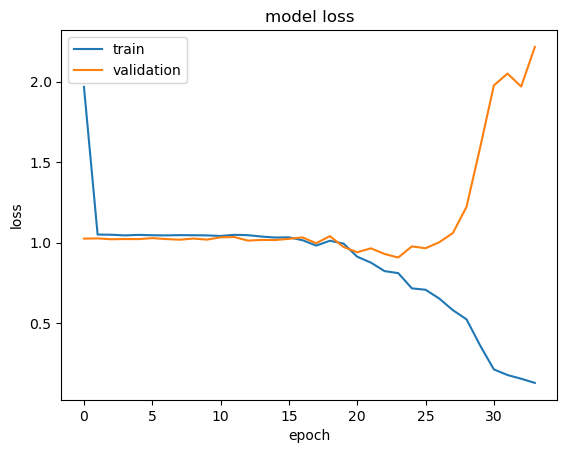

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()